In [1]:
# Load results
import os
import pandas as pd

results = pd.DataFrame()
results_path = "./results/extraction/paraphrase_chat/"
result_file_list = os.listdir(results_path)
for filename in result_file_list:
    df = pd.read_csv(results_path + filename, names = ["filename", "turn", "full_summary", "omitted_summary", "similarity"])
    results = pd.concat([results, df])


/tmp/ipykernel_238672/3648564014.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, df])


In [2]:
# Cast dtype
results = results.astype({"similarity": float, "turn": int})

results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 8
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         952 non-null    object 
 1   turn             952 non-null    int64  
 2   full_summary     952 non-null    object 
 3   omitted_summary  952 non-null    object 
 4   similarity       952 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 44.6+ KB


In [3]:
# Remove duplicates
results = results.drop_duplicates(subset=["filename", "turn"], keep="last")

#print(results)

Text(0, 0.5, 'Frequency')

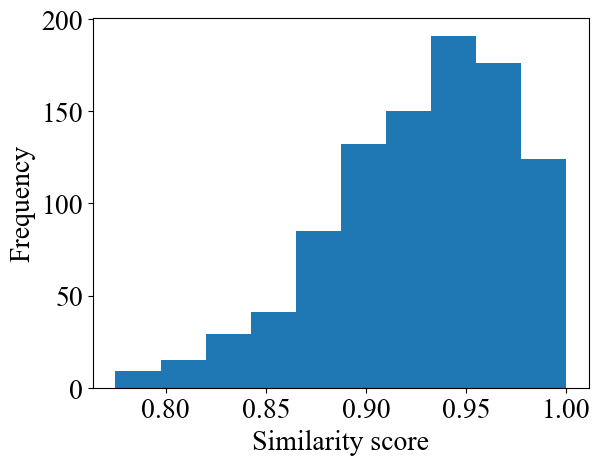

In [4]:
# Show histogram
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
plt.rcParams["font.size"] = 20                 # 文字の大きさ

hist = plt.hist(results["similarity"])
plt.xlabel("Similarity score")
plt.ylabel("Frequency")

Text(0, 0.5, '頻度')

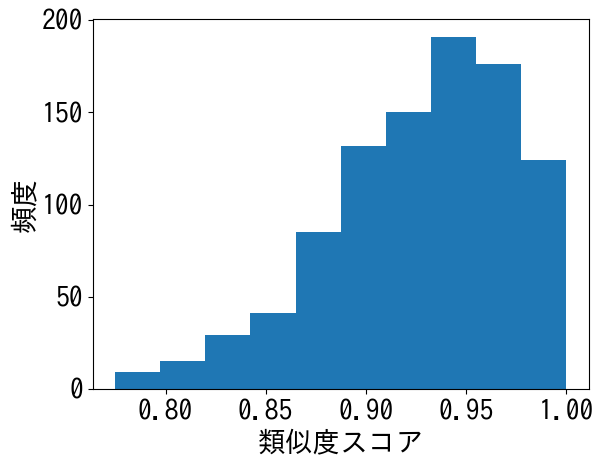

In [5]:
# Show histogram (Japanese)
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.rcParams["font.family"] = "IPAGothic"   # 使用するフォント
plt.rcParams["font.size"] = 20                 # 文字の大きさ

hist = plt.hist(results["similarity"])
plt.xlabel("類似度スコア")
plt.ylabel("頻度")

In [ ]:
# Sort by similarity
results = results.sort_values("similarity")
#results = results.reset_index()

#print(results)

In [ ]:
# Show top and bottom
def show_row(row):
    with open("./dat/" + row.filename) as f:
        dialogue = [l.rstrip() for l in f.readlines()]
    
    full_dialogue = "\n".join(dialogue[:row.turn + 1])
    print("-----------------")
    print("filename")
    print(row.filename)
    print("full dialogue")
    print(full_dialogue)
    print("full summary")
    print(row.full_summary)
    print("omitted summary")
    print(row.omitted_summary)
    print("similarity") 
    print(row.similarity)
    return

NUM_EXAMPLES = 5
for row in results.head(NUM_EXAMPLES).itertuples():
    show_row(row)

for row in results.tail(NUM_EXAMPLES).itertuples():
    show_row(row)



In [ ]:
# Show graph
import matplotlib.pyplot as plt
DIALOGUE_NUMBER = 98

result = results.query(f"filename == 'PP{DIALOGUE_NUMBER}.txt'")
result = result.sort_values("turn", ascending=True)

with open(f"./dat/PP{DIALOGUE_NUMBER}.txt") as f:
    dialogue = [l.rstrip() for l in f.readlines()]

dialogue_with_line_number = []
for idx, l in enumerate(dialogue):
    dialogue_with_line_number.append(str(idx) + ". " + l)

print("\n".join(dialogue_with_line_number))
result.plot(x="turn", y="similarity")

In [ ]:
# Count number of sentences similarity < 0.9
threshold = 0.85
under_threshold = results["similarity"] < threshold
n_under_threshold = under_threshold.sum()
print(n_under_threshold)
results_under_threshold = results[under_threshold]
bottom_results = results_under_threshold.reset_index()

In [ ]:
# Collect top samples with the same number as under threshold
top_results = results.tail(n_under_threshold)
top_results = top_results.reset_index()
top_threshold = top_results["similarity"].min()
print(top_threshold)

In [ ]:
# Create samples for survey
n_sample = 5
sample_size_low = 10
sample_size_high = 0

samples = []
for i in range(n_sample):
    sample = pd.DataFrame(columns=bottom_results.columns)
    n_rows = 0
    while n_rows < sample_size_low:
        low_candidate = bottom_results.sample(n=1)
        low_candidate["condition"] = "low"
        sample = pd.concat([sample, low_candidate])
        sample = sample.drop_duplicates(keep="first", subset="filename")
        n_rows = len(sample)
    bottom_results.drop(sample.head(sample_size_low).index, inplace=True)

    while n_rows < sample_size_low + sample_size_high:
        high_candidate = top_results.sample(n=1)
        high_candidate["condition"] = "high"
        sample = pd.concat([sample, high_candidate])
        sample = sample.drop_duplicates(keep="first", subset="filename")
        n_rows = len(sample)
    top_results.drop(sample.tail(sample_size_high).index, inplace=True)

    # Check filename
    print(sample["filename"])    
    samples.append(sample)


In [4]:
# Create samples for dataset
n_sample = 48
samples = []
sample_sizes = []

# Calculate sample sizes
min_sample_size = len(results) // n_sample
remainder = len(results) % n_sample
for i in range(0, n_sample):
    if i < remainder:
        sample_sizes.append(min_sample_size + 1)
    else:
        sample_sizes.append(min_sample_size)

# Divide results into samples
rest_results = results.reset_index(drop=True)
for i in range(0, n_sample):
    sample = rest_results.sample(n=sample_sizes[i])
    rest_results = rest_results.drop(sample.index)
    sample = sample.reset_index(drop=True)

    samples.append(sample)



In [5]:
import random

def replace_duplicate(samples, sample_from, from_idx, duplicate_filename):
    # Choose sample_to
    sample_order = list(range(0, n_sample))
    random.shuffle(sample_order)
    sample_to_is_found = False
    for j in sample_order:
        duplicate_count = (samples[j]["filename"] == duplicate_filename).sum()
        if duplicate_count == 0:
            sample_to_is_found = True
            sample_to = j
            break

    if not sample_to_is_found:
        print("sample to is not found")
        return
    
    # Choose dialogue
    dialogue_is_found = False
    for index, row in samples[j].iterrows():
        another_filename = row["filename"]
        another_count = (samples[sample_from]["filename"] == another_filename).sum()
        if another_count == 0:
            dialogue_is_found = True
            to_idx = index
            break
    
    if not dialogue_is_found:
        print("replaceable dialogue is not found")
        return
    
    # Replace data
    data_from = samples[sample_from].iloc[from_idx]
    data_to = samples[sample_to].iloc[to_idx]
    samples[sample_from].iloc[from_idx] = data_to.values
    samples[sample_to].iloc[to_idx] = data_from.values
    print(f"replaced data {from_idx} in {sample_from} and data {to_idx} in {sample_to}")
    return samples

In [6]:
# Replace duplicate dialogue
perfect = False
while not perfect:
    duplicates = 0
    for i in range(0, n_sample):
        filename_count = samples[i].groupby("filename").count()
        if max(filename_count["turn"]) > 1:
            duplicates = 1
            duplicate_filename = filename_count["turn"].idxmax()
            from_idx = (samples[i].query("filename == @duplicate_filename").index[0])
            new_samples = replace_duplicate(
                samples=samples,
                sample_from=i, 
                from_idx=from_idx, 
                duplicate_filename=duplicate_filename
            )
            samples = new_samples.copy()
            break
        
    if duplicates == 0:
        perfect = True
        print("perfect!")

for i in range(0, n_sample):
    print(samples[i]["filename"])
    print("------")

replaced data 2 in 0 and data 0 in 36
replaced data 12 in 1 and data 0 in 46
replaced data 10 in 2 and data 0 in 19
replaced data 11 in 3 and data 0 in 47
replaced data 2 in 4 and data 0 in 34
replaced data 1 in 4 and data 1 in 17
replaced data 2 in 5 and data 1 in 30
replaced data 7 in 6 and data 1 in 10
replaced data 16 in 8 and data 0 in 47
replaced data 0 in 8 and data 0 in 3
replaced data 1 in 9 and data 0 in 6
replaced data 0 in 10 and data 0 in 26
replaced data 11 in 11 and data 1 in 2
replaced data 5 in 12 and data 0 in 36
replaced data 6 in 15 and data 0 in 22
replaced data 4 in 15 and data 0 in 35
replaced data 0 in 15 and data 0 in 11
replaced data 15 in 17 and data 1 in 20
replaced data 8 in 17 and data 0 in 0
replaced data 18 in 18 and data 1 in 33
replaced data 7 in 18 and data 1 in 15
replaced data 5 in 19 and data 0 in 40
replaced data 0 in 20 and data 0 in 40
replaced data 9 in 20 and data 0 in 12
replaced data 13 in 20 and data 0 in 23
replaced data 2 in 21 and data 0

In [ ]:
# Create CSV for assistance
import csv

SPEAKERS = ["A: ", "B: "]

for sample_number, sample in enumerate(samples):
    shuffled_sample = sample.sample(frac=1)
    sample_CSV = pd.DataFrame({
        "sample_number": [],
        "dialogue_number": [],
        "full_dialogue": [],
        "assist_utterance": []
        })
    sample_CSV = sample_CSV.astype({
        "sample_number": int,
        "dialogue_number": int,
        "full_dialogue": str,
        "assist_utterance": str
    })
    for dialogue_number, row in enumerate(shuffled_sample.itertuples()):
        with open("./dat/" + row.filename) as f:
            dialogue = [l.rstrip() for l in f.readlines()]
        
        full_dialogue = "\n".join(dialogue[:row.turn + 1])
        sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
            "sample_number": [int(sample_number)],
            "dialogue_number": [int(dialogue_number)],
            "full_dialogue": [full_dialogue],
            "assist_utterance": [""]
        })])

    csv_filename = "./forms/assist{:03}.csv".format(sample_number)
    sample_CSV.to_csv(csv_filename)



In [9]:
# Create CSV
import csv

SPEAKERS = ["A: ", "B: "]

for idx, sample in enumerate(samples):
    shuffled_sample = sample.sample(frac=1)
    sample_CSV = pd.DataFrame({
        "full_dialogue": [],
        "omitted_dialogue": [],
        "core_sentence": [],
        "condition": []
    })
    for row in shuffled_sample.itertuples():
        with open("./dat/" + row.filename) as f:
            dialogue = [l.rstrip() for l in f.readlines()]
        
        full_dialogue = "\n\n".join(dialogue[:row.turn + 1])
        omitted_dialogue = "\n\n".join(dialogue[:row.turn - 2] + dialogue[row.turn:row.turn + 1])
        core_sentence = dialogue[row.turn]
        for speaker in SPEAKERS:
            core_sentence = core_sentence.removeprefix(speaker)
        condition = row.condition
        sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
        "full_dialogue": [full_dialogue],
        "omitted_dialogue": [omitted_dialogue],
        "core_sentence": [core_sentence],
        "condition": [condition]
        })])

    csv_filename = "./forms/sample{:03}.csv".format(idx + 1)
    sample_CSV.to_csv(csv_filename)



In [8]:
# Create CSV for dataset
import csv

SPEAKERS = ["A: ", "B: "]

for idx, sample in enumerate(samples):
    shuffled_sample = sample.sample(frac=1)
    sample_CSV = pd.DataFrame({
        "filename": [],
        "turn": [],
        "omitted_dialogue": [],
        "core_sentence": [],
        "similarity": []
    })
    sample_CSV = sample_CSV.astype({
        "filename": str,
        "turn": int,
        "omitted_dialogue": str,
        "core_sentence": str,
        "similarity": str
    })
    for row in shuffled_sample.itertuples():
        with open("./dat/" + row.filename) as f:
            dialogue = [l.rstrip() for l in f.readlines()]
        
        full_dialogue = "\n\n".join(dialogue[:row.turn + 1])
        omitted_dialogue = "\n\n".join(dialogue[:row.turn - 2] + dialogue[row.turn:row.turn + 1])
        core_sentence = dialogue[row.turn]
        for speaker in SPEAKERS:
            core_sentence = core_sentence.removeprefix(speaker)
        sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
        "filename": [row.filename],
        "turn": [row.turn],
        "omitted_dialogue": [omitted_dialogue],
        "core_sentence": [core_sentence],
        "similarity": [row.similarity]
        })])

    csv_filename = "./forms/dataset{:03}.csv".format(idx + 1)
    sample_CSV.to_csv(csv_filename)



/tmp/ipykernel_238672/2127780456.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
/tmp/ipykernel_238672/2127780456.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
/tmp/ipykernel_238672/2127780456.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determini

In [4]:
# Create CSV for dataset evaluation
import pandas as pd
import csv

SPEAKERS = ["A: ", "B: "]

for idx in range(0, 50):
    sample_CSV = pd.DataFrame({
        "filename": [],
        "turn": [],
        "complete_dialogue": [],
        "core_sentence": [],
        "similarity": []
    })
    sample_CSV = sample_CSV.astype({
        "filename": str,
        "turn": int,
        "complete_dialogue": str,
        "core_sentence": str,
        "similarity": str
    })
    filenames = ["PP" + str(idx * 2 + 1) + ".txt", "PP" + str(idx * 2 + 2) + ".txt"]
    for filename in filenames:
        with open("./dat/" + filename) as f:
            dialogue = [l.rstrip() for l in f.readlines()]
        for turn, core_sentence in enumerate(dialogue[3:], 3):
            full_dialogue = "\n\n".join(dialogue)
            for speaker in SPEAKERS:
                core_sentence = core_sentence.removeprefix(speaker)
            sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
                "filename": [filename],
                "turn": [turn],
                "complete_dialogue": [full_dialogue],
                "core_sentence": [core_sentence],
                "similarity": [1]
            })])

    csv_filename = "./forms/dataset{:03}eval.csv".format(idx + 1)
    sample_CSV.to_csv(csv_filename)



In [6]:
# Create tex
import pandas as pd
n_samples = 50

for survey_idx in range(0, n_samples):

    SURVEY_NUMBER = survey_idx + 1
    #csv_filename = "./forms/sample{:03}.csv".format(SURVEY_NUMBER)
    csv_filename = "./forms/dataset{:03}eval.csv".format(SURVEY_NUMBER)
    sample_CSV = pd.read_csv(csv_filename)

    head_path = "./tex/head.tex"
    with open(head_path) as head_file:
        head_tex = head_file.read()
    tail_path = "./tex/tail.tex"
    with open(tail_path) as tail_file:
        tail_tex = tail_file.read()

    for idx, row in enumerate(sample_CSV.itertuples()):
        underlined_core_sentence = "\\ul{" + row.core_sentence + "}"
        underlined_full = row.complete_dialogue.replace(row.core_sentence, underlined_core_sentence)
        #full_path = "./forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "full.tex"
        full_path = "./forms/dataset" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "full.tex"
        with open(full_path, mode='w') as output_file:
            output_file.write(head_tex)
            output_file.write(underlined_full)
            output_file.write(tail_tex)

        #full_name = "forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "full"
        full_name = "forms/dataset" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "full"
        !ptex2pdf -l {full_name} -output-directory "forms/"


        # underlined_omitted = row.omitted_dialogue.replace(row.core_sentence, underlined_core_sentence)
        # #omitted_path = "./forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "omitted.tex"
        # omitted_path = "./forms/dataset" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "omitted.tex"
        # with open(omitted_path, mode='w') as output_file:
        #     output_file.write(head_tex)
        #     output_file.write(underlined_omitted)
        #     output_file.write(tail_tex)

        # #omitted_name = "forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "omitted"
        # omitted_name = "forms/dataset" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "omitted"
        # !ptex2pdf -l {omitted_name} -output-directory "forms/"


This is ptex2pdf[.lua] version 20200520.0.
Processing forms/dataset001_000full
This is e-pTeX, Version 3.141592653-p4.1.0-230214-2.6 (utf8.euc) (TeX Live 2023) (preloaded format=platex)
 restricted \write18 enabled.
entering extended mode
(./forms/dataset001_000full.tex(guessed encoding #3: UTF-8 = utf8)
pLaTeX2e <2023-02-14>+1 (based on LaTeX2e <2022-11-01> patch level 1)
L3 programming layer <2023-04-20>
(/usr/local/texlive/2023/texmf-dist/tex/latex/amscls/amsart.cls(guessed encoding #5: ASCII = utf8)
Document Class: amsart 2020/05/29 v2.20.6
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsmath.sty(guessed encoding #6: ASCII = utf8)
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amstext.sty(guessed encoding #7: ASCII = utf8)
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsgen.sty(guessed encoding #8: ASCII = utf8)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsbsy.sty(guessed encoding #7: 

In [ ]:
# Load importance data
import os
import pandas as pd

importance_data = pd.DataFrame()
importance_path = "./results/extraction/important_chat/"
importance_file_list = os.listdir(importance_path)
for filename in importance_file_list:
    df = pd.read_csv(importance_path + filename, names = ["filename", "first", "second"])
    importance_data = pd.concat([importance_data, df])

# Cast dtype
importance_data = importance_data.astype({"first": int, "second": int})

# Remove duplicates
importance_data = importance_data.drop_duplicates(subset=["filename"], keep="last")

importance_data.info()

In [ ]:
# Combine similarity and importance
combined_data = pd.DataFrame(
    columns=["filename", "turn", "utterance", "low_similarity", "important"]
)

n_dialogue = 100
threshold = 0.85

for idx_dialogue in range(1, n_dialogue + 1):
    filename = "PP" + str(idx_dialogue) + ".txt"
    with open("./dat/" + filename) as f:
        dialogue = [l.rstrip() for l in f.readlines()]

    importance_row = importance_data.query(
        "filename == @filename"
    )

    for idx_utterance, utterance in enumerate(dialogue):
        summary_row = results.query(
            "filename == @filename and (turn == @idx_utterance + 1 or turn == @idx_utterance + 2)"
        )
        if len(summary_row.query("similarity < @threshold")) > 0:
            int_low_similarity = 1
        else:
            int_low_similarity = 0

        if len(importance_row.query(
            "first == @idx_utterance + 1 or second == @idx_utterance + 1"
        )) > 0:
            int_important = 1
        else:
            int_important = 0

        new_data = pd.DataFrame({
            "filename": [filename],
            "turn": [idx_utterance + 1],
            "utterance": [utterance],
            "low_similarity": [int_low_similarity],
            "important": [int_important]
        })
        combined_data = pd.concat([combined_data, new_data])

print(combined_data)



In [ ]:
# Save as CSV
for dialogue_idx in range(1, n_dialogue + 1):
    dialogue_filename = "PP" + str(dialogue_idx) + ".txt"
    sample_data = combined_data.query("filename == @dialogue_filename")
    csv_filename = "./tmp/combined" + str(dialogue_idx) + ".csv"
    sample_data.to_csv(csv_filename)

In [ ]:
# Show cross table
crossed = pd.crosstab(combined_data["low_similarity"], combined_data["important"])
print(crossed)

In [ ]:
# Chi-square test
import scipy as sp
import scipy.stats

chi2_stats = sp.stats.chi2_contingency(crossed)
print(chi2_stats)

In [ ]:
# List important SCAINs
important_scain = combined_data.query("low_similarity == 1 and important ==1")
print(important_scain)